In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn

from torchsummary import summary

In [2]:
def normalization(data):
  data_mean = np.mean(data, axis=0)
  data_std  = np.std(data, axis=0)
  data_norm = (data - data_mean) / data_std
  data_norm = np.nan_to_num(data_norm, nan=0) # 欠損値(nan)を0で置換
  del data_mean, data_std
  return data_norm

def indexing(lead_time):
  output_shape = 2
  rt = real_time2[:-lead_time-1]
  t_data = PC_norm[lead_time:]
  print(t_data.shape)
  idx = np.where((rt.year <= 2015))[0]
  t_train = t_data[idx]
  idx = np.where((rt.year > 2015))[0]
  t_test = t_data[idx]
  print('t_train, t_test =', t_train.shape, t_test.shape)
  return rt, t_train, t_test, output_shape

def preprocess(data, rt, lead_time):
  ipt_lag0  = data[10:-lead_time-1]
  ipt_lag5  = data[5:-lead_time-6]
  ipt_lag10 = data[:-lead_time-11]
  # =========
  # 検証データのみ
  idx2 = np.where((rt.year > 2015))[0]
  ipt_lag0_test = ipt_lag0[idx2]
  ipt_lag5_test = ipt_lag5[idx2]
  ipt_lag10_test = ipt_lag10[idx2]
  ipt_test = np.stack([ipt_lag0_test, ipt_lag5_test, ipt_lag10_test], 3)
  return ipt_test

In [3]:
def culc_cor(predict, y_test, lead_time):
  cor = (np.sum(predict[:,0] * y_test[:,0], axis=0) + np.sum(predict[:,1] * y_test[:,1], axis=0)) / \
          (np.sqrt(np.sum(predict[:,0] ** 2 + predict[:,1] ** 2, axis=0)) * np.sqrt(np.sum(y_test[:,0] ** 2 + y_test[:,1] ** 2, axis=0)))
  print('cor = '.format(lead_time), cor)
  return cor

In [4]:
class Conv(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Sequential(
          nn.Conv2d(8*3, 32, kernel_size=3, stride=2, padding=1),
          nn.BatchNorm2d(32),
          nn.ReLU(),
          nn.Dropout(0.2))
        self.layer2 = nn.Sequential(
          nn.Conv2d(32, 64, kernel_size=2, stride=2, padding=1),
          nn.BatchNorm2d(64), 
          nn.ReLU(),
          nn.Dropout(0.2))
        self.layer3 = nn.Sequential(
          nn.Conv2d(64, 128, kernel_size=2, stride=2, padding=1),
          nn.BatchNorm2d(128),
          nn.ReLU(),
          nn.Dropout(0.2))
        self.fc1 = nn.Sequential(
          nn.Linear(128*4*19, 128),
          nn.BatchNorm1d(128),
          nn.ReLU(),
          nn.Dropout(0.2))
        self.fc2 = nn.Linear(128, 2)
        #self.fc1 = nn.Linear(128*4*19, 2)
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = x.reshape(x.size(0), -1)
        x = self.fc1(x)
        x = self.fc2(x)
        return x


In [30]:
if __name__ == '__main__':
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  
  #mode = 'mjo'
  mode = 'bsiso'
  data = np.load('/home/maeda/data/bsiso_eeof/prepro_anomaly_8vals.npz')

  olr = data['olr'][80:,24:49,:]
  u850 = data['u850'][80:,24:49,:]
  v850 = data['v850'][80:,24:49,:]
  u200 = data['u200'][80:,24:49,:]
  v200 = data['v200'][80:,24:49,:]
  h850 = data['h850'][80:,24:49,:]
  pr_wtr = data['pr_wtr'][80:,24:49,:]
  sst = data['sst'][80:,24:49,:]

  lat = data['lat'][24:49]
  lon = data['lon']
  time = data['time'][80:]    # 射影後にデータが10日進むため、時刻の方を前進させておく
  real_time = pd.to_datetime(time, unit='h', origin=pd.Timestamp('1800-01-01')) # 時刻をdatetime型に変換

  x = np.stack([olr, u850, v850, u200, v200, h850, pr_wtr, sst], 3)
  x_n = np.zeros(x.shape)
  for i in range(x.shape[3]):
    x_n[:,:,:,i] = normalization(x[:,:,:,i])
  print('x_n = ', x_n.shape)  
  x_test = []

  # bsiso index (eEOF) 読み込み
  if mode == 'bsiso':
    data_file = '/home/maeda/data/bsiso_eeof/bsiso_rt-PCs.npz'
  elif mode == 'mjo':
    data_file = '/home/maeda/data/bsiso_eeof/mjo_rt-PCs.npz'
  PC      = np.load(data_file)['rt_PCs'][:,:2]
  sign    = np.array([-1, 1]).T
  PC_norm = sign * PC / PC.std(axis=0)[np.newaxis,:]
  time2   = np.load(data_file)['time']
  real_time2 = pd.to_datetime(time2, unit='h', origin=pd.Timestamp('1800-01-01')) # 時刻をdatetime型に変換
  print('PCs = ', PC_norm.shape)
  print('time PCs= ', time2.shape)
  print('real time PCs = ', real_time2[0], real_time2[-1])

  def test_step(x, t):
    model.eval()
    preds = model(x)
    loss = loss_fn(preds, t)
    return loss, preds
  

  #lt_box = [0, 5, 10, 15, 20, 25, 30, 35]
  lt_box = np.arange(0, 31, 5)
  lt_max = 30
  seed_box = [0, 7, 7, 9, 5, 1, 2, 1, 1, 8, 
              5, 1, 1, 0, 5, 3, 3, 4, 5, 2,
              3, 3, 3, 5, 5, 6, 6, 7, 2, 6,
              5]
  result = np.zeros((7, 25, 2525, 2))
  loss = np.zeros((7, 25))
  cor  = np.zeros((7, 25))
  count = 0
  for lead_time in lt_box:
    print('==== lead time : {} day ====='.format(lead_time))
    path = f'/home/maeda/machine_learning/results/model/kikuchi-8vals_v1/8vals/model_{(lead_time):03}day/seed{(seed_box[lead_time]):03}.pth'

    # answer data
    rt, t_train, t_test, output_shape = indexing(lead_time)
    print('rt, t_train, t_test = ', rt.shape, t_train.shape, t_test.shape)
    # input data
    x_test = []
    for i in range(8):
      _x_test = preprocess(x_n[:,:,:,i], rt, lead_time)
      x_test.append(_x_test)
    x_test = np.stack(np.array(x_test), 3).reshape(-1, 25, 144, 8*3).transpose(0, 3, 1, 2)
    print('x_test =', x_test.shape)
    rt, t_train, t_test, output_shape = indexing(lead_time)
    print('rt, t_train, t_test =', rt.shape, t_train.shape, t_test.shape)
    # model
    model = Conv().to(device)
    model.load_state_dict(torch.load(path, map_location=device))
    
    # x_test のチャンネルごとの０埋め
    for i in range(9):
      x_test_i = x_test.copy()
      if i == 0:
        x_test_i = x_test_i
      else:  # ！！同じ変数のラグは８チャンネルずつ飛んでいることに注意！！
        x_test_i[:,(i-1)*3:i*3,:,:] = 0
      loss_fn = nn.MSELoss()
      x_test_i = torch.Tensor(x_test_i).to(device)
      t_test = torch.Tensor(t_test).to(device)
      test_loss, preds_test = test_step(x_test_i, t_test)
      print('loss: {:.3}'.format(
        test_loss.item()
        ))  
      
      predict = preds_test.cpu().detach().numpy()
      t_test  = t_test.cpu().detach().numpy()
      test_loss = test_loss.cpu().detach().numpy()
        
      cor[count, i]     = culc_cor(predict, t_test, lead_time)
      result[count, i]  = predict[:-1-(lt_max-lead_time)]
      loss[count, i]    = test_loss
    count += 1
  print(result.shape, loss.shape, cor.shape)


/tmp/ipykernel_206641/730915222.py:4: RuntimeWarning: invalid value encountered in divide
  data_norm = (data - data_mean) / data_std


x_n =  (15991, 25, 144, 8)
PCs =  (15981, 2)
time PCs=  (15981,)
real time PCs =  1979-04-01 00:00:00 2022-12-31 00:00:00
==== lead time : 0 day =====
(15981, 2)
t_train, t_test = (13424, 2) (2556, 2)
rt, t_train, t_test =  (15980,) (13424, 2) (2556, 2)
x_test = (2556, 24, 25, 144)
(15981, 2)
t_train, t_test = (13424, 2) (2556, 2)
rt, t_train, t_test = (15980,) (13424, 2) (2556, 2)
loss: 0.00882
cor =  0.9948673
loss: 0.634
cor =  0.780704
loss: 0.0142
cor =  0.9946
loss: 0.00886
cor =  0.99486774
loss: 0.00967
cor =  0.99479467
loss: 0.00957
cor =  0.9946405
loss: 0.00932
cor =  0.99485266
loss: 0.0094
cor =  0.99456155
loss: 0.00887
cor =  0.9948685
==== lead time : 5 day =====
(15976, 2)
t_train, t_test = (13424, 2) (2551, 2)
rt, t_train, t_test =  (15975,) (13424, 2) (2551, 2)
x_test = (2551, 24, 25, 144)
(15976, 2)
t_train, t_test = (13424, 2) (2551, 2)
rt, t_train, t_test = (15975,) (13424, 2) (2551, 2)
loss: 0.0729
cor =  0.9564913
loss: 0.382
cor =  0.8404317
loss: 0.0803
cor =

In [31]:
# BMSD
BMSD = np.zeros((7, 9))
for i in range(BMSD.shape[0]):
  for j in range(BMSD.shape[1]):
    BMSD[i, j] = ((result[i, j, :, 0] - result[i, 0, :, 0])**2 + (result[i, j, :, 1] - result[i, 0, :, 1])**2).sum(axis=0) / 2525

[[0.00000000e+00 1.22579292e+00 1.24970076e-02 2.55181618e-04
  2.08777269e-03 1.27431517e-03 2.41676868e-03 1.10751643e-03
  1.36578112e-04]
 [0.00000000e+00 6.07803554e-01 2.83518788e-02 2.64586936e-03
  2.94485931e-02 5.01453979e-03 1.52102556e-02 5.31977237e-03
  6.89600695e-03]
 [0.00000000e+00 2.54387660e-01 5.08634062e-02 1.13489452e-02
  6.45101653e-02 1.14660536e-02 2.72043450e-02 1.76358388e-02
  3.67960270e-02]
 [0.00000000e+00 8.74615193e-02 3.56831288e-02 1.26993012e-02
  9.67002811e-02 1.23659220e-02 3.63772578e-02 4.26082807e-02
  6.30588465e-02]
 [0.00000000e+00 7.71207621e-02 3.80062609e-02 2.05736913e-02
  7.04301192e-02 1.33779349e-02 3.18827575e-02 4.92680289e-02
  6.39884379e-02]
 [0.00000000e+00 6.82638830e-02 4.29889678e-02 1.45457305e-02
  7.61698287e-02 2.19603284e-02 3.56874744e-02 8.45895139e-02
  5.89935048e-02]
 [0.00000000e+00 5.91893345e-02 6.38409365e-02 2.06135389e-02
  5.50984215e-02 2.16116601e-02 2.49328558e-02 5.90255173e-02
  4.20580498e-02]]


(0.0, 1.0)

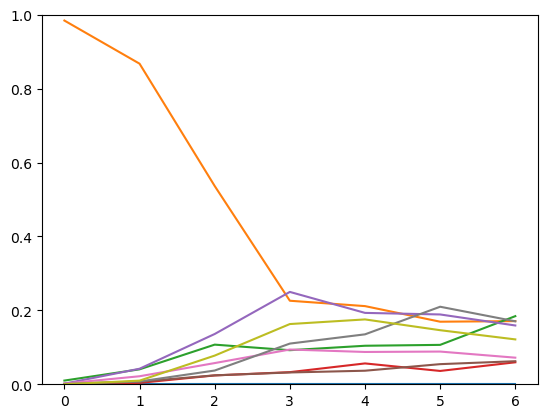

In [32]:
print(BMSD)
ratio = BMSD / BMSD.sum(axis=1, keepdims=True)
plt.plot(BMSD / BMSD.sum(axis=1, keepdims=True), label='ratio')

plt.ylim(0, 1)

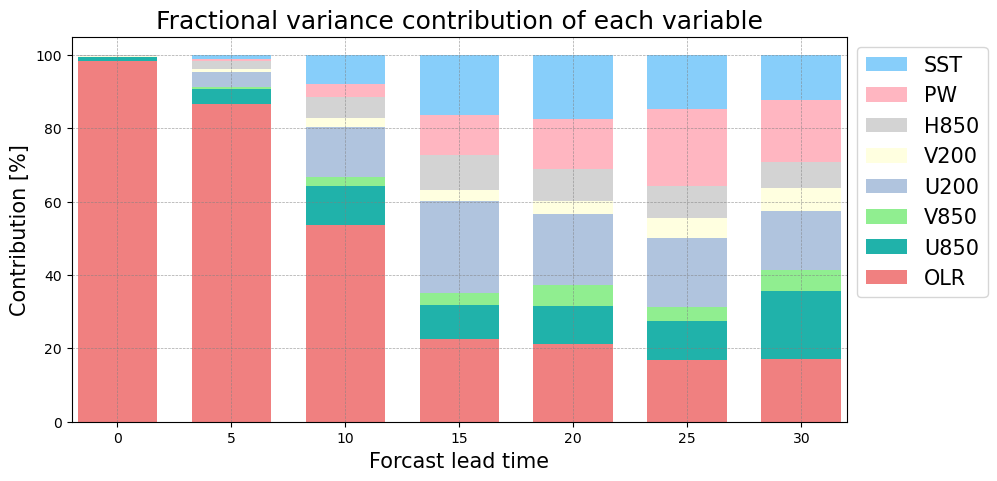

In [33]:
tt_box = [0, 5, 10, 15, 20, 25, 30]
# color は　柔らかい色で
c_box = ['lightcoral', 'lightseagreen', 'lightgreen', 'lightsteelblue', 'lightyellow', 'lightgrey', 'lightpink','lightskyblue']
val = ['OLR', 'U850', 'V850', 'U200', 'V200', 'H850', 'PW', 'SST']
fig, ax = plt.subplots(figsize=(10, 5))
for i in range(1,9):
    ax.bar(tt_box, ratio[:,i]*100, bottom=ratio[:,1:i].sum(axis=1)*100, label=val[i-1], width=3.5, color=c_box[i-1])
ax.set_xlabel('Forcast lead time', fontsize=15)
ax.set_ylabel('Contribution [%]', fontsize=15)
ax.set_title('Fractional variance contribution of each variable', fontsize=18)

plt.ylim(0, 105)
plt.xlim(-2, 32)
# legend の表示を逆順
handles, labels = ax.get_legend_handles_labels()
plt.legend(fontsize=15,loc='upper left', bbox_to_anchor=(1, 1), handles=handles[::-1],labels=labels[::-1])
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)
plt.show()

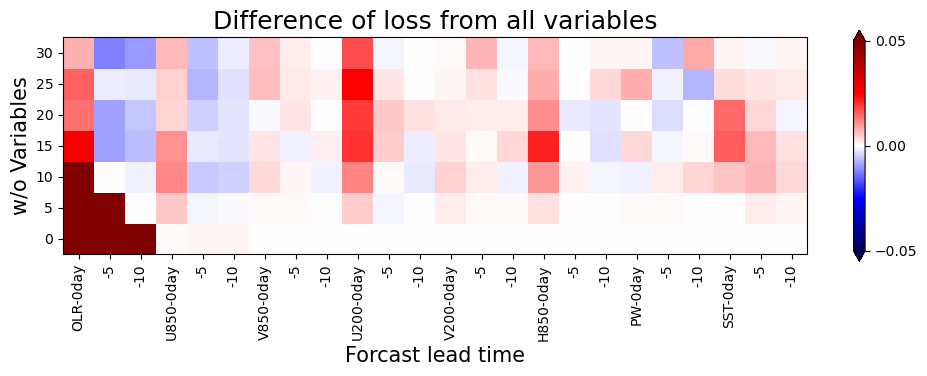

In [28]:
# ２次元ヒートマップ
diff_loss = loss - loss[:,0][:,np.newaxis]
val = ['OLR-0day', '-5', '-10',
       'U850-0day', '-5', '-10',
       'V850-0day', '-5', '-10',
       'U200-0day', '-5', '-10',
       'V200-0day', '-5', '-10',
       'H850-0day', '-5', '-10',
       'PW-0day', '-5', '-10',
       'SST-0day', '-5', '-10']
fig, ax = plt.subplots(figsize=(12, 6))

#im = ax.imshow(diff_loss[:,1:], cmap='seismic', vmin=-0.1, vmax=0.1)
im = ax.pcolor(diff_loss[:,1:], cmap='seismic', vmin=-0.05, vmax=0.05)
plt.gca().set_aspect('equal', adjustable='box')
ax.set_xticks(np.arange(0.5, 24.5, 1))
ax.set_yticks(np.arange(0.5, 7.5, 1))
ax.set_xticklabels(val, rotation=90)
ax.set_yticklabels(tt_box)
# 0.00 が真ん中に来るように
plt.colorbar(im, extend='both', ticks=[-0.05, 0, 0.05], shrink=0.5)
plt.title('Difference of loss from all variables', fontsize=18)
plt.ylabel('w/o Variables', fontsize=15)
plt.xlabel('Forcast lead time', fontsize=15)
plt.show()


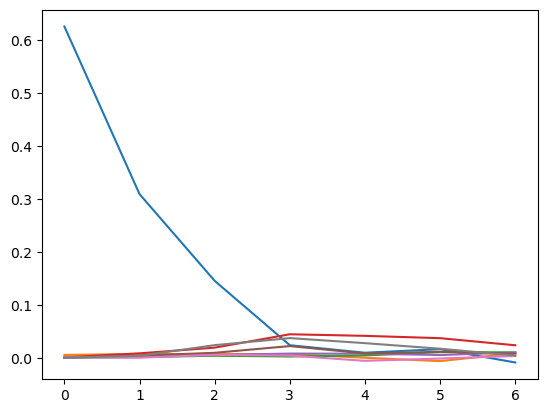

In [147]:
plt.plot(diff_loss[:,1:], label=val)